## A Comprehensive Data Analysis on a WhatsApp Group Chat

### Overview
1. Introduction
2. Data Retrieval & Preprocessing
3. Exploratory Data Analysis
4. Data Visualization
5. Data Interpretation
6. Summarizing the Inferences
7. Conclusion

Introduction:

Analyzing WhatsApp group chat data provides a valuable opportunity for individuals to leverage their analytical and computational skills in a practical context. Through mathematical analysis and computational proficiency, insights into communication patterns, social dynamics, and collective behaviors within group ecosystems can be derived. By applying data science methodologies such as natural language processing and machine learning, actionable insights can be extracted from unstructured text data, facilitating deeper understanding and interpretation of group interactions. This interdisciplinary approach not only enhances analytical capabilities but also has practical applications across diverse domains, including data science, market research, and social media analytics.

### How do I export my conversations? From Where To Obtain Data?

1. The first step is ``Data Retrieval & Preprocessing``, that is to ``gather the data``. WhatsApp allows you to ``export your chats`` through a .txt format.

2. Go to the respective chat, which you want to export!

3. Tap on ``options``, click on ``More``, and ``Export Chat``.

Export ``Without Media``.
``NOTE``:
1. Without media: exports about **40k messages **
2. With media: exports about 10k messages along with pictures/videos
3. While exporting data, avoid including media files because if the number of media files is greater than certain figure then not all the media files are exported.


### Importing Necessary Libraries
We will be using :

1.``Regex (re)`` to extract and manipulate strings based on specific patterns.

References:

        Regex - Python Docs
        Regex cheatsheet
        Regex Test - live
        Datetime Format
2. ``pandas`` for analysis.
3. ``matlotlib and seaborn`` for visualization.
4. ``emoji`` to deal with emojis.

References:
   
       Python Docs
       Emoji
       EMOJI CHEAT SHEET
   
5. ``wordcloud`` for the most used words.

In [1]:
# Importing libraries

import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from wordcloud import WordCloud, STOPWORDS
import emoji
import itertools 
from collections import Counter
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

### Preparation and reading data

In [2]:
def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''
    
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%m/%d/%y, %I:%M %p - ',
        '24hr' : '%m/%d/%Y, %H:%M - ',
        'custom': ''
    }
    
    with open(file, 'r', encoding='utf-8') as raw_data:
        # print(raw_data.read())        
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # Splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # Finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # Exporting it to a df
        
        
    # Converting date-time pattern which is of type String to type datetime,
    # Format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    # Split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # Lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # User typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # Other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            msgs.append(a[0])

    # Creating new columns   
    df['user'] = usernames
    df['message'] = msgs

    # Dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

### Pre-Processing

In [3]:
df = rawToDf('WhatsApp Chat with BMC Legends.txt', '12hr')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5378 entries, 0 to 5377
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  5378 non-null   datetime64[ns]
 1   user       5378 non-null   object        
 2   message    5378 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 126.2+ KB


In [5]:
# Sample of the dataset
df.sample(10)

,date_time,user,message
768,2020-09-08 09:27:00,Gladys BMC,Anakuanga stingy na notes excess
429,2020-09-01 15:20:00,Bella Chausiku,<Media omitted>
1396,2020-09-16 11:35:00,Joe,si tulisema hakuna kitu ka hii
2099,2021-06-23 11:29:00,Dante,"sasa sisi tutajuaje alibadilisha time, 😂😂 say ..."
4075,2021-12-08 11:57:00,Caroline BMC,Alaaa Kuna classes mbili?
5036,2022-09-27 11:32:00,Caroline BMC,Watu wa applied walifanya nini kwani juzi😂😂😂
1228,2020-09-15 10:14:00,Silvanus,yea
3405,2021-10-13 08:04:00,Claire Opiyo,We will have the Scientific Computing class o...
1317,2020-09-15 10:49:00,Ones,Aaah kumbe imebaki 19 minutes 😂😂
734,2020-09-08 08:52:00,Caroline BMC,Hiyo haikuwa ya mwisho sweetie😂😂ni kubaya


An important observation

One might wonder there are no NaNs, but as you can see, there are some rows with emojis, others where messages will be an empty string.
This can be because, the message might just contain emojis.

In [6]:
df[df['message'] == ""].shape[0]

99

In [7]:
# Extracting unique users

unique_users = df['user'].unique()
total_unique_users = len(unique_users)

print("The total number of users are:" + str(total_unique_users) + "\n" +'Exclude -1 for group_notification ')
print('\n')
print(unique_users) 

The total number of users are:71
Exclude -1 for group_notification 


['group_notification' 'Bella Chausiku' '+254 707 842471' 'Joe' 'Ezekiel'
 'Mwilu Harrison' 'Patrick Omondi' 'Pato' '+254 727 397377'
 'Justus Ndegwa' 'Ones' 'Gabriel Wachira' '+254 794 726344' 'Claire Opiyo'
 '+254 723 714312' 'Caroline BMC' 'Joseph' 'Karis' '+254 757 109750'
 '+254 746 761906' 'Stephen' 'Kevin Makenge' '+254 721 583889'
 'Julius Otieno' 'Dante BMC' 'Eunice Kamau' '+254 742 416662' 'Matthew'
 'Eric' 'Moses Barini' 'Festus' '+254 746 723598' 'Réúbén' 'Cate'
 'Steve Chacha' 'Faey' 'Gladys BMC' 'Lillian' '+254 746 299771' 'Silvanus'
 'Mohaga' '+254 707 392541' '+254 729 833163' 'Nathan' "Mark Ndung'e"
 '+254 786 935867' 'Emmanuel' '+254 716 225382' 'Peter Kioko'
 'Nderitu Pius' '+254 715 894309' 'Ephantus' '+254 775 137582' 'Alan'
 'Boaz' '+254 710 661438' '+254 796 489971' 'Big Sam Calvin'
 'Jimmy Ombati' 'Dante' '+254 789 793281' '+254 729 927160' 'Betty'
 '+254 705 898939' '+254 717 804344' '+254 112

In [8]:
# Counting occurrences of each unique user
user_counts = df['user'].value_counts()

# Converting the Series to a DataFrame
user_counts_df = user_counts.reset_index()

# Renaming the columns
user_counts_df.columns = ['user', 'Count']

# Set display options to show all rows 
pd.set_option('display.max_rows', None)

# Displaying the DataFrame
user_counts_df


,user,Count
0,Claire Opiyo,770
1,Joe,587
2,Caroline BMC,495
3,Ones,413
4,group_notification,256
5,Steve Chacha,210
6,+254 727 397377,187
7,Mwilu Harrison,185
8,Gladys BMC,180
9,Kevin Makenge,170


### Adding extra helper columns for analysis and visualization

In [9]:
df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())

In [10]:
df

,date_time,user,message,day,month,year,date
0,2020-01-23 15:40:00,group_notification,"+254 786 288780 created group ""BMC Legends""",Thu,Jan,2020,2020-01-23
1,2020-01-23 15:40:00,group_notification,You were added,Thu,Jan,2020,2020-01-23
2,2020-05-14 07:53:00,Bella Chausiku,Please resend tena,Thu,May,2020,2020-05-14
3,2020-05-20 16:53:00,+254 707 842471,<Media omitted>,Wed,May,2020,2020-05-20
4,2020-05-20 22:22:00,Joe,<Media omitted>,Wed,May,2020,2020-05-20
5,2020-05-20 22:23:00,Joe,watu i need help fixing the error on this,Wed,May,2020,2020-05-20
6,2020-05-23 06:39:00,Ezekiel,Any one who had my no please conduct me nipate...,Sat,May,2020,2020-05-23
7,2020-05-23 14:24:00,Mwilu Harrison,Toa kwa group,Sat,May,2020,2020-05-23
8,2020-05-23 16:01:00,Ezekiel,I gave simple instructions and is only for tho...,Sat,May,2020,2020-05-23
9,2020-05-23 17:20:00,Patrick Omondi,😂,Sat,May,2020,2020-05-23


### 1. Overall frequency of total messages on the group.

In [11]:
df1 = df.copy()      # I will be using a copy of the original data frame everytime, to avoid loss of data!
df1['message_count'] = [1] * df1.shape[0]      # adding extra helper column --> message_count.
df1.drop(columns='year', inplace=True)         # dropping unnecessary columns, using `inplace=True`, since this is copy of the DF and won't affect the original DataFrame.
df1 = df1.groupby('date').sum().reset_index()  # grouping by date; since plot is of frequency of messages --> no. of messages / day.
df1

,date,message_count
0,2020-01-23,2
1,2020-05-14,1
2,2020-05-20,3
3,2020-05-23,7
4,2020-05-27,11
5,2020-05-28,2
6,2020-05-29,2
7,2020-05-31,3
8,2020-06-04,1
9,2020-06-05,7


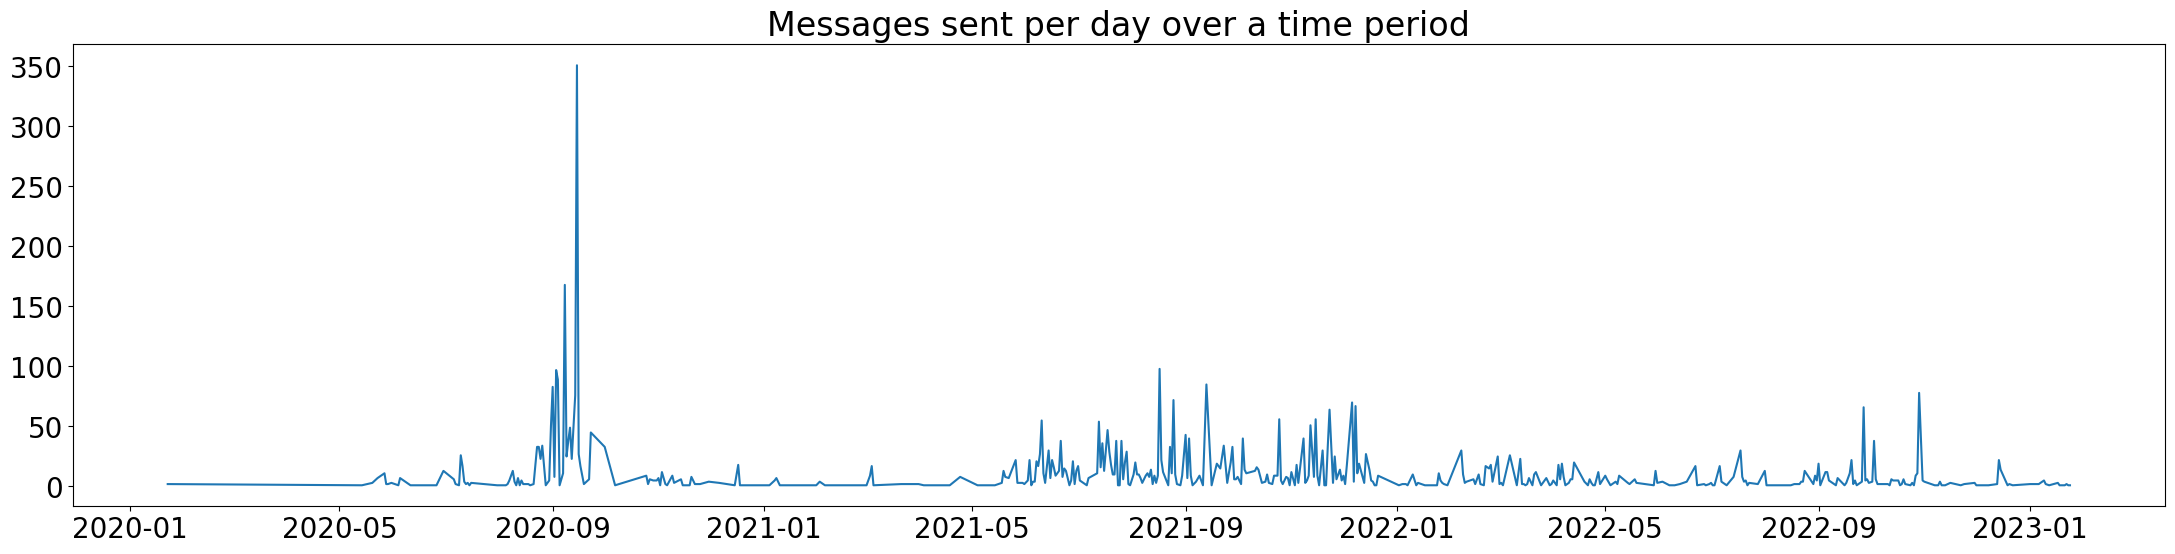

In [12]:
# For better readablity

matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)      # Same as `plt.figure(figsize = (27, 6))`


# A basic plot
plt.plot(df1.date, df1.message_count)
plt.title('Messages sent per day over a time period')

# Could have used Seaborn's lineplot as well.
# sns.lineplot(df1.date, df1.message_count);   

# Saving the plots
plt.savefig('msg_plots.svg', format = 'svg')


### 2. Top 10 most active days

In [13]:
top10days = df1.sort_values(by="message_count", ascending=False).head(10)    # Sort values according to the number of messages per day.
top10days.reset_index(inplace=True)           # reset index in order.
top10days.drop(columns="index", inplace=True) # dropping original indices.
top10days

,date,message_count
0,2020-09-15,351
1,2020-09-08,168
2,2021-08-17,98
3,2020-09-03,97
4,2020-09-04,89
5,2021-09-13,85
6,2020-09-01,83
7,2022-10-29,78
8,2020-09-14,76
9,2021-08-25,72


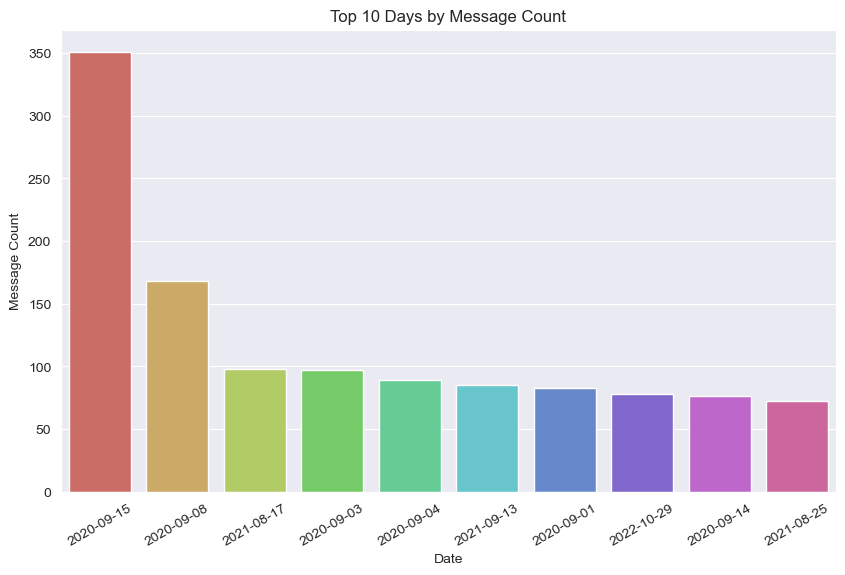

In [14]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# Set the figure size
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (10, 6)

# Create a bar plot for top 10 days
sns.barplot(data=top10days, x='date', y='message_count', palette="hls")

# Rotate x-axis labels for better readability
plt.xticks(rotation= 30)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Message Count')
plt.title('Top 10 Days by Message Count')

# Saving the plot
plt.savefig('top10_days.svg', format='svg')

# Show the plot
plt.show()


### 3. Top 10 active users on the group.

In [15]:
# Total number of people who have sent at least one message on the group

print(f"Total number of people who have sent at least one message on the group are {len(df.user.unique()) - 1}")   # `-1` because excluding "group_notficiation"

Total number of people who have sent at least one message on the group are 70


In [16]:
print(f"Number of people who haven't sent even a single message on the group are {71 - len(df.user.unique()) - 1}")

Number of people who haven't sent even a single message on the group are -1


In [17]:
df2 = df.copy()    
df2 = df2[df2.user != "group_notification"]
top10df = df2.groupby("user")["message"].count().sort_values(ascending=False)

# Final Data Frame
top10df = top10df.head(10).reset_index()
top10df

,user,message
0,Claire Opiyo,770
1,Joe,587
2,Caroline BMC,495
3,Ones,413
4,Steve Chacha,210
5,+254 727 397377,187
6,Mwilu Harrison,185
7,Gladys BMC,180
8,Kevin Makenge,170
9,Lillian,137


### Bottom 10 active users on the group.

In [18]:
df2 = df.copy()    
df2 = df2[df2.user != "group_notification"]
bottom10df = df2.groupby("user")["message"].count().sort_values(ascending=False)

# Final Data Frame
bottom10df = bottom10df.tail(10).reset_index()
bottom10df

,user,message
0,+254 796 489971,1
1,+254 710 710506,1
2,+254 728 704010,1
3,+254 711 574655,1
4,Big Sam Calvin,1
5,+254 789 793281,1
6,+254 775 137582,1
7,Hacker👽💻 Silvanus,1
8,+254 746 723598,1
9,Boaz,1


### Now, visualizing top 10 active users.
Replacing names with initials for better visualization

In [19]:
# Assuming top10df is your DataFrame containing the top 10 users
for i in range(len(top10df)):
    # Splitting the user name into first and last names
    name_parts = top10df.loc[i, 'user'].split()
    
    # Checking if there are at least two name parts
    if len(name_parts) >= 2:
        # Extracting the first letter of the first and last names to form initials
        initials = name_parts[0][0].upper() + name_parts[1][0].upper()
    else:
        # If the name doesn't have two parts, take the first two letters of the first name and capitalize
        initials = name_parts[0][:2]
    
    # Assigning the initials to the 'initials' column
    top10df.loc[i, 'initials'] = initials

# Dropping the avg_message_length column if it exists
if 'avg_message_length' in top10df.columns:
    top10df.drop(columns=['avg_message_length'], inplace=True)

# Displaying the updated DataFrame
print(top10df)


              user  message initials
0     Claire Opiyo      770       CO
1              Joe      587       Jo
2     Caroline BMC      495       CB
3             Ones      413       On
4     Steve Chacha      210       SC
5  +254 727 397377      187       +7
6   Mwilu Harrison      185       MH
7       Gladys BMC      180       GB
8    Kevin Makenge      170       KM
9          Lillian      137       Li


In [20]:
# For better readablity;

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

##### Plotting a simple line graph.

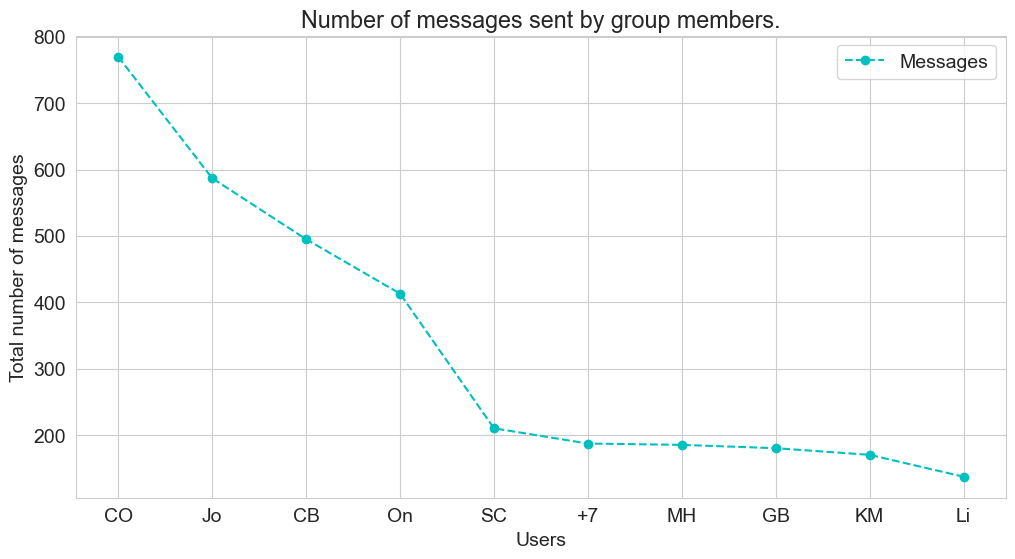

In [21]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))

# plt.plot(top10df.initials, top10df.message, marker='o', ls='--', c='cyan')

# BETTER IMPLEMENTATION using the `fmt` argument;
plt.plot(top10df.initials, top10df.message, 'o--c')  


# Labels and Title 
plt.xlabel('Users')
plt.ylabel('Total number of messages')

plt.title("Number of messages sent by group members.")
plt.legend(['Messages']);

# Saving the plots
# plt.savefig('msg_plots.svg', format = 'svg')

##### Plotting a bar chart and line graph together.

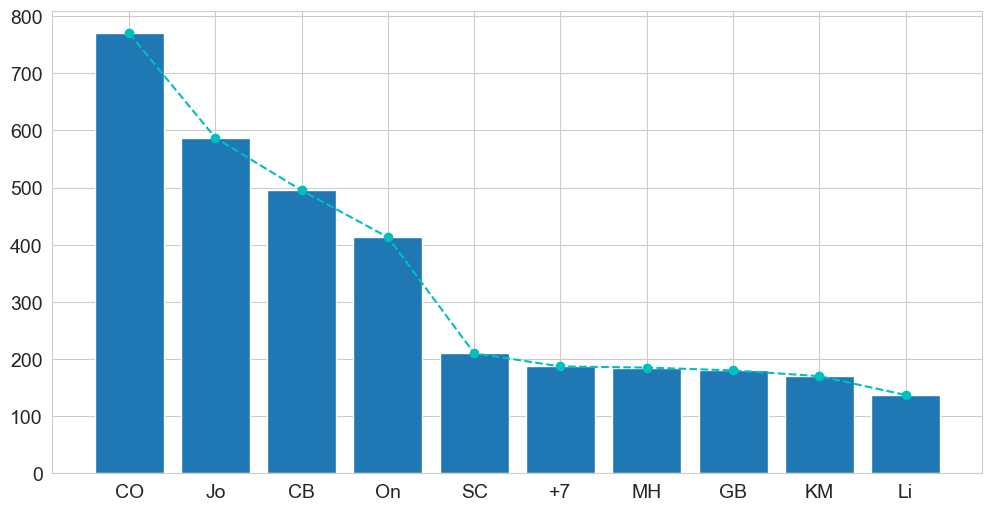

In [22]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12,6))

plt.bar(top10df.initials, top10df.message)   # basic bar chart
plt.plot(top10df.initials, top10df.message, 'o--c');   # line chart

<Axes: xlabel='initials', ylabel='message'>

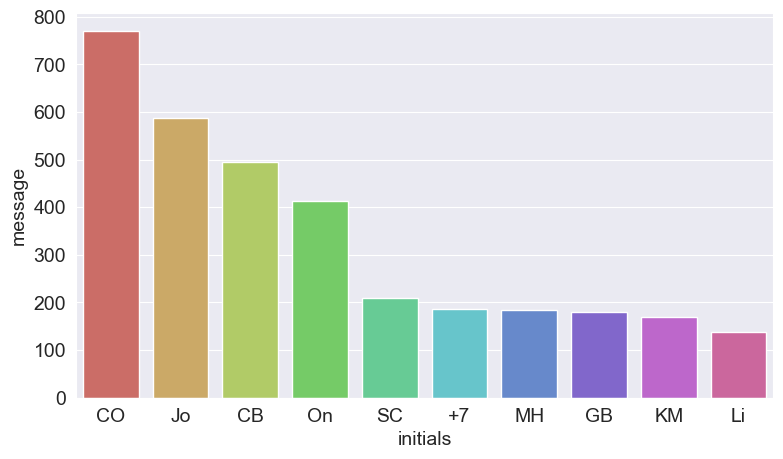

In [23]:
# Beautifying Default Styles using Seaborn

sns.set_style("darkgrid")
sns.barplot(data=top10df, x='initials', y='message', palette="hls")

### Important Note

Since almost all the plots will be ***comparing* one person with another, will be assigning a **specific colour to each person so that it becomes easy to identify each person among multiple plots.

Seaborn assigns default colors itself, but the color of a certain person should remain the same, no matter the plot;

The dictionary is created where each key is the name and the value for each would be their assigned colour. Creating a function which reorders colours given a list of names to match the ordering of the plot. This function takes the ordered names as input and returns a reordered list of colours. This list has to be passed into the pallete argument in a seaborn plotting function.

### Defining a function to tackle the problem.

Defining the following function to maintain consistent colors for each person across all plots. Since the order will vary depending on the plot, this is passed to the function which will reorder colors in a particular order so that the color of a certain person remains the same no matter the plot. This will help maintain consistency and readability amongst the many graphs I will be plotting.

In [24]:
def get_colors_of_certain_order(names_in_certain_order):
    '''the color of a certain person remains the same, no matter the plot'''
    
    order = list(names_in_certain_order)
    return_list = []
    
    for name in order:
        return_list.append(color_dict[name])
        
    return return_list

{'CO': '#F94144',
 'Jo': '#F3722C',
 'CB': '#F8961E',
 'On': '#FDC500',
 'SC': '#F9C74F',
 '+7': '#90BE6D',
 'MH': '#43AA8B',
 'GB': '#577590',
 'KM': '#6D597A',
 'Li': '#003F88'}

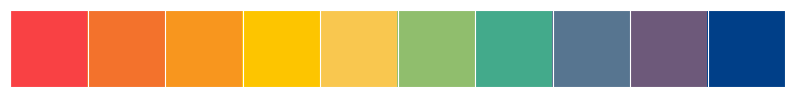

In [25]:
colors = ['#F94144', '#F3722C', '#F8961E', '#FDC500', '#F9C74F', '#90BE6D', '#43AA8B', '#577590', '#6D597A','#003F88']
sns.palplot(colors)    # visualizing the colors' list

names = top10df.initials

color_dict = {}
for name, color in zip(names, colors):
    color_dict[name] = color
color_dict

#### average message length of the 10 most active users

In [26]:
# Adding another column for message length; using the apply method;
df2['message_length'] = df2['message'].apply(lambda x: len(x))      

# Creating another dataframe for average length per user;
avg_msg_lengths = df2.groupby(df2.user).mean().reset_index().sort_values(by = 'message_length', ascending = False)

# Creating helper columns;
top10df['avg_message_length'] = [0] * 10
i, j = 0, 0
while i < 10:
    if top10df['user'][i] == avg_msg_lengths['user'][j]:
        top10df['avg_message_length'][i] = avg_msg_lengths['message_length'][j]
        i += 1
        j = -1
    j += 1

# Sorting the average message lengths of the same to 10 active users;
top10df_msg = top10df.sort_values(by = "avg_message_length", ascending=False)

top10df_msg

,user,message,initials,avg_message_length
0,Claire Opiyo,770,CO,48.687013
4,Steve Chacha,210,SC,41.266667
9,Lillian,137,Li,39.218978
8,Kevin Makenge,170,KM,39.152941
1,Joe,587,Jo,38.260647
6,Mwilu Harrison,185,MH,32.259459
5,+254 727 397377,187,+7,24.946524
3,Ones,413,On,24.605327
2,Caroline BMC,495,CB,21.668687
7,Gladys BMC,180,GB,21.638889


#### most sent messages and respective average message lengths

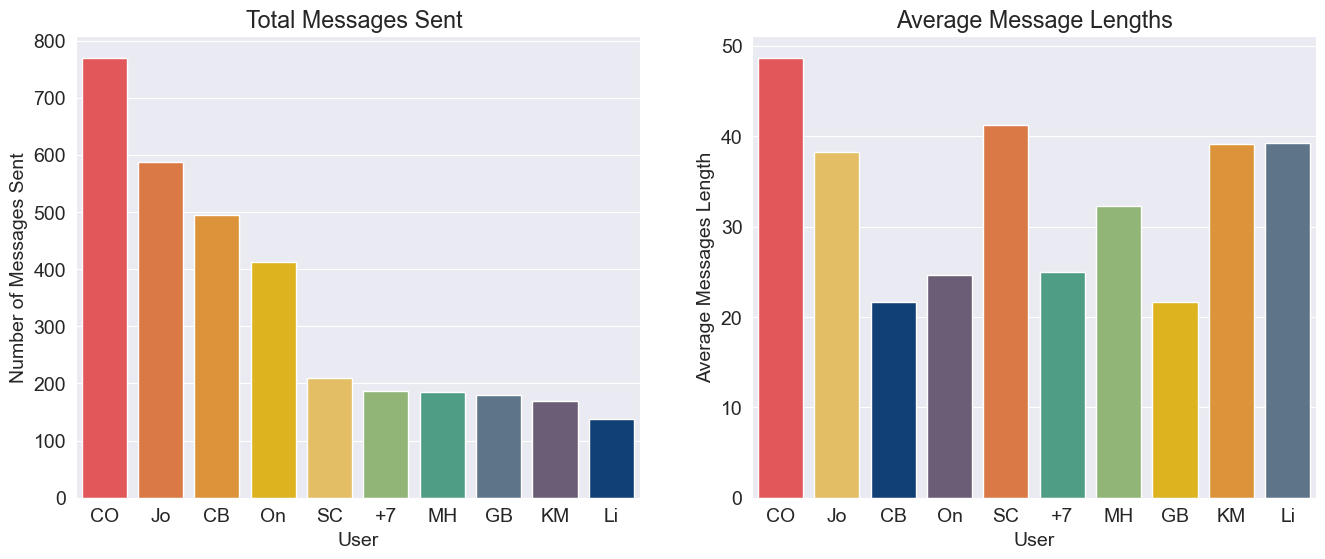

In [27]:
# plotting multiple charts in a grid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("darkgrid")

# Plot 1 - Countplot of total messages sent
sns.barplot(data=top10df, x='initials', y='message',ax = axes[0], palette=get_colors_of_certain_order(top10df.initials)) 

axes[0].set_title('Total Messages Sent ')
axes[0].set_xlabel('User')
axes[0].set_ylabel('Number of Messages Sent')



# Plot 2 - Barplot of those top 10 users' average message lengths
sns.barplot(data=top10df, x='initials', y='avg_message_length', ax = axes[1], palette = get_colors_of_certain_order(top10df_msg.initials)) 

axes[1].set_title('Average Message Lengths')
axes[1].set_xlabel('User');
axes[1].set_ylabel('Average Messages Length');

# Saving the plots
plt.savefig('top10_msg_plots_diff.svg', format = 'svg')

### 4. Top 10 users most sent media

The exported chats were exported without any media files. Any message that contained media was indicated with ``<Media Omitted> ``.

In [28]:
# Using `groupby`, `count` and `sort_values` attributes.
top10media = df[df.message == '<Media omitted> '].groupby('user').count().sort_values(by="message", ascending=False).head(10)

# Dropping unused column;
top10media.drop(columns=['date_time', 'day', 'month', 'year', 'date'], inplace=True)

# Renaming column name for visualization;
top10media.rename(columns={"message": "media_sent"}, inplace=True)

# Resetting index;
top10media.reset_index(inplace=True)

# Adding initials column and populating it
top10media['initials'] = ''
for i in range(10):
    name_parts = top10media.user[i].split()
    if len(name_parts) >= 2:
        # If there are at least two name parts, take the first letter of each part and capitalize
        initials = name_parts[0][0].upper() + name_parts[1][0].upper()
    else:
        # If the name has only one part, take the first two letters and capitalize
        initials = name_parts[0][:2]
    top10media.at[i, 'initials'] = initials

# Manually assigning initials
top10media.at[2, 'initials'] = "ME"  # That's me
top10media.at[9, 'initials'] = "VR"

print(top10media)

              user  media_sent initials
0     Claire Opiyo         180       CO
1   Bella Chausiku          71       BC
2     Steve Chacha          43       ME
3             Ones          38       On
4  +254 727 397377          18       +7
5              Joe          18       Jo
6    Julius Otieno          14       JO
7            Betty          11       Be
8             Pato          10       Pa
9  +254 721 583889          10       VR


### Visualization using different Seaborn's Color Palettes

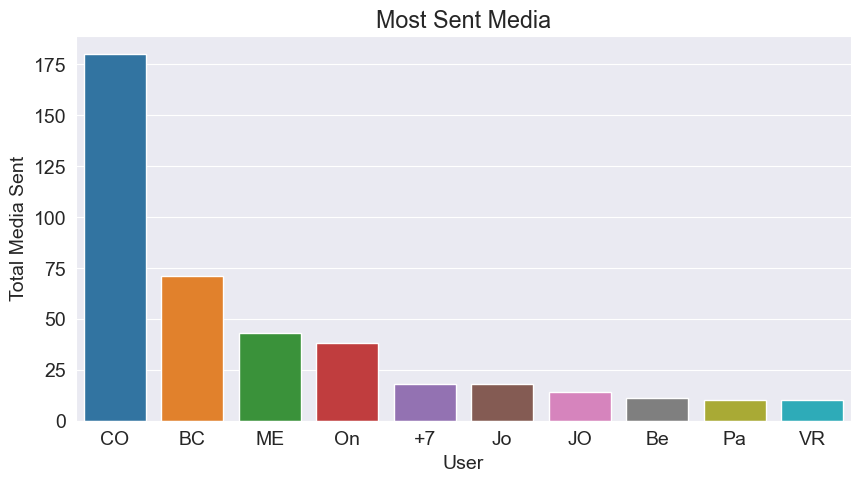

In [29]:
# Increasing the figure size
plt.figure(figsize=(10, 5))

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting a bar graph;
sns.barplot(data = top10media, x= 'initials', y='media_sent') # palette="CMRap"

plt.title('Most Sent Media')
plt.xlabel('User')
plt.ylabel('Total Media Sent');

# Saving the plots
plt.savefig('top10media.svg', format = 'svg')

Claire Opiyo (CO) is beating everyone by a mile, followed by Bella Chausiku (BC). She also ranks the top in total messages, though last in average message length. Most dedicated contributor award goes to CO!

### 5. Top 10 most used Emojis

Will be using the ``emoji`` module, that was imported earlier.

In [30]:
emoji_ctr = Counter()
emojis_list = map(lambda x: ''.join(x.split()), emoji.EMOJI_DATA.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
    emojis_found = r.findall(row["message"])
    for emoji_found in emojis_found:
        emoji_ctr[emoji_found] += 1

#### Will create another helper column using emoji.demojize("<emoji>"), since emojis will not rendered.

In [31]:
top10emojis = pd.DataFrame()

top10emojis['emoji'] = [''] * 10
top10emojis['emoji_count'] = [0] * 10
top10emojis['emoji_description'] = [''] * 10

i = 0
for item in emoji_ctr.most_common(10):
    # will be using another helper column, since during visualization, the emojis won't be rendered.
    description = emoji.demojize(item[0])[1:-1]    # using `[1:-1]` to remove the colons ':' at the end of the demojized strin
    
    # appending top 10 data of emojis.  # Loading into a DataFrame.
    top10emojis.emoji[i] = item[0]
    top10emojis.emoji_count[i] = int(item[1])
    top10emojis.emoji_description[i] = description
    i += 1

top10emojis

,emoji,emoji_count,emoji_description
0,😂,2939,face_with_tears_of_joy
1,🤣,351,rolling_on_the_floor_laughing
2,😅,122,grinning_face_with_sweat
3,😹,66,cat_with_tears_of_joy
4,🏾,65,medium-dark_skin_tone
5,😭,48,loudly_crying_face
6,🏽,41,medium_skin_tone
7,♀️,34,female_sign
8,🤔,32,thinking_face
9,😄,29,grinning_face_with_smiling_eyes


#### Which Emoji is the most used in the chat?

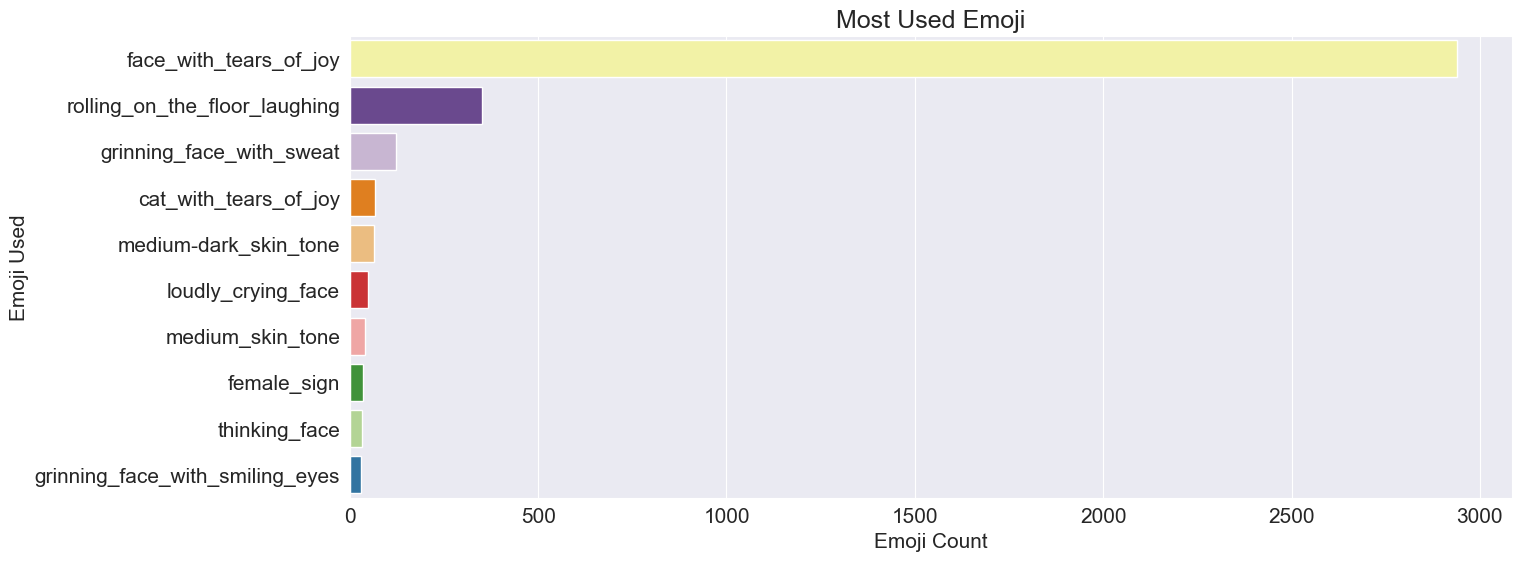

In [32]:
# Increasing the figure size
plt.figure(figsize=(15, 6))

# Better Readablity
matplotlib.rcParams['font.size'] = 15

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting
sns.barplot(data = top10emojis, x= 'emoji_count', y='emoji_description', palette = "Paired_r")

plt.title('Most Used Emoji')
plt.xlabel('Emoji Count')
plt.ylabel('Emoji Used');

# Saving the plots
plt.savefig('top10emoji.svg', format = 'svg')

### 6. Most active days, most active hours, most active months.

#### Pre-processing

In [33]:
df3 = df.copy()
df3['message_count'] = [1] * df.shape[0]    # helper column to keep a count.

df3['hour'] = df3['date_time'].apply(lambda x: x.hour)

grouped_by_time = df3.groupby('hour').sum().reset_index().sort_values(by = 'hour')

### Which hour of the day are most messages exchanged?

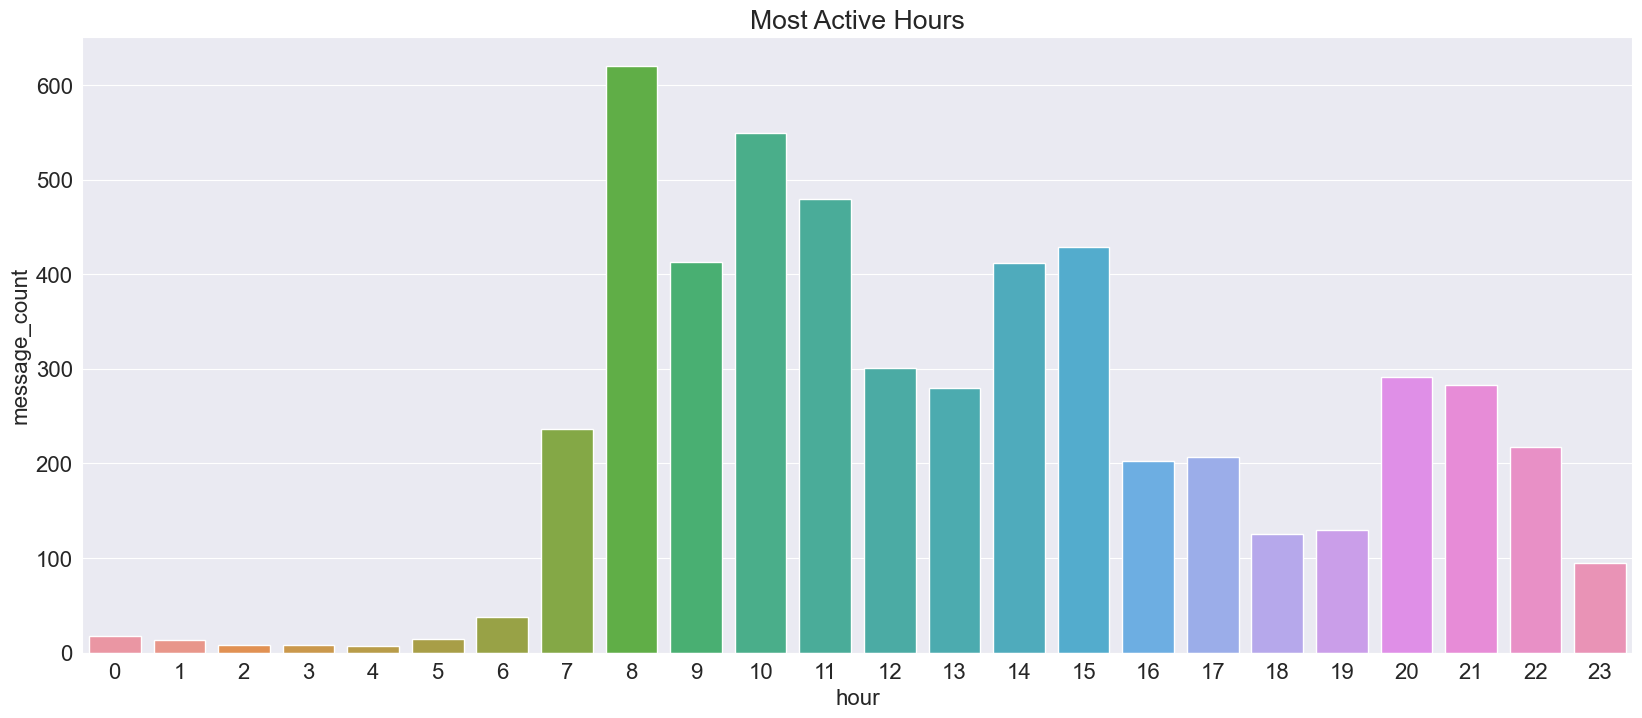

In [34]:
# Better Readablity

matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (20, 8)

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# PLOT: grouped by hour
sns.barplot(data = grouped_by_time, x= 'hour', y= 'message_count')
plt.title('Most Active Hours');

# Saving the plots;
plt.savefig('most_active_hours.svg', format = 'svg')

### Pre-processing weekdays and months

In [35]:
# specific `order` to be printed in;
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# grouping by day;
grouped_by_day = df3.groupby('day').sum().reset_index()[['day', 'message_count']]


# specific `order` to be printed in;
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']   # till Sept, since chats are till Septemeber
# grouping by month;
grouped_by_month = df3.groupby('month').sum().reset_index()[['month', 'message_count']]

### plotting grouped by day and respective group by month simultaneousl

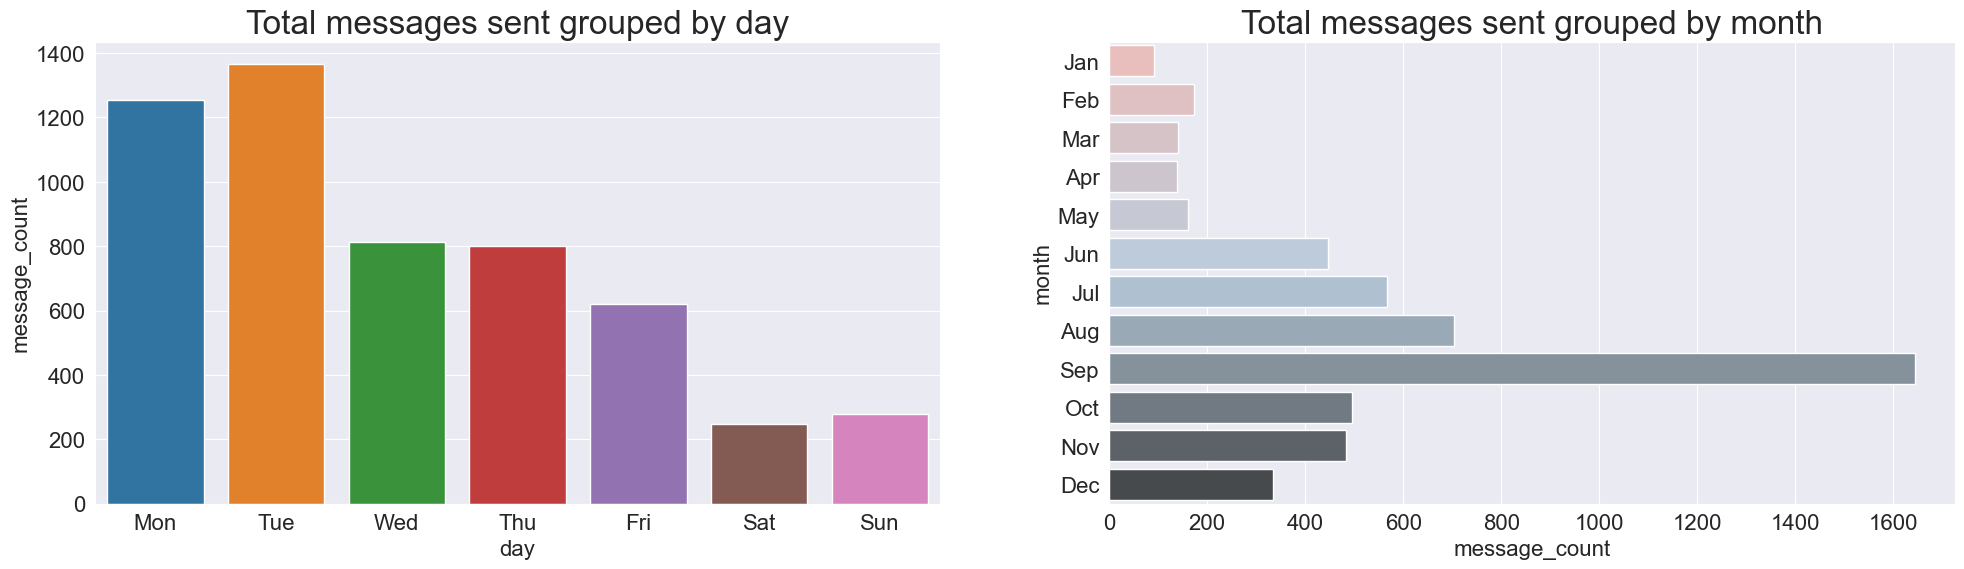

In [36]:
fig, axs = plt.subplots(1, 2, figsize = (24, 6))

# Better Readablity

matplotlib.rcParams['font.size'] = 20

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting;

# PLOT 1: Messages grouped by weekday
sns.barplot(data = grouped_by_day, x = 'day', y = 'message_count', order= days, ax = axs[0])
axs[0].set_title('Total messages sent grouped by day')

# PLOT 2: Messages grouped by months
sns.barplot(y = grouped_by_month.month, x=grouped_by_month.message_count, order = months, ax = axs[1], palette='Pastel1_d')
axs[1].set_title('Total messages sent grouped by month');

# Saving the plots;
plt.savefig('days_and_month.svg', format = 'svg')

The group is most active on weekdays, and least active on the weekends (probably because there little or no class to attend to)

It has been recently very active, in September.

#### Now, we will plot a heatmap, combining the above to bar plots, for a better understanding!

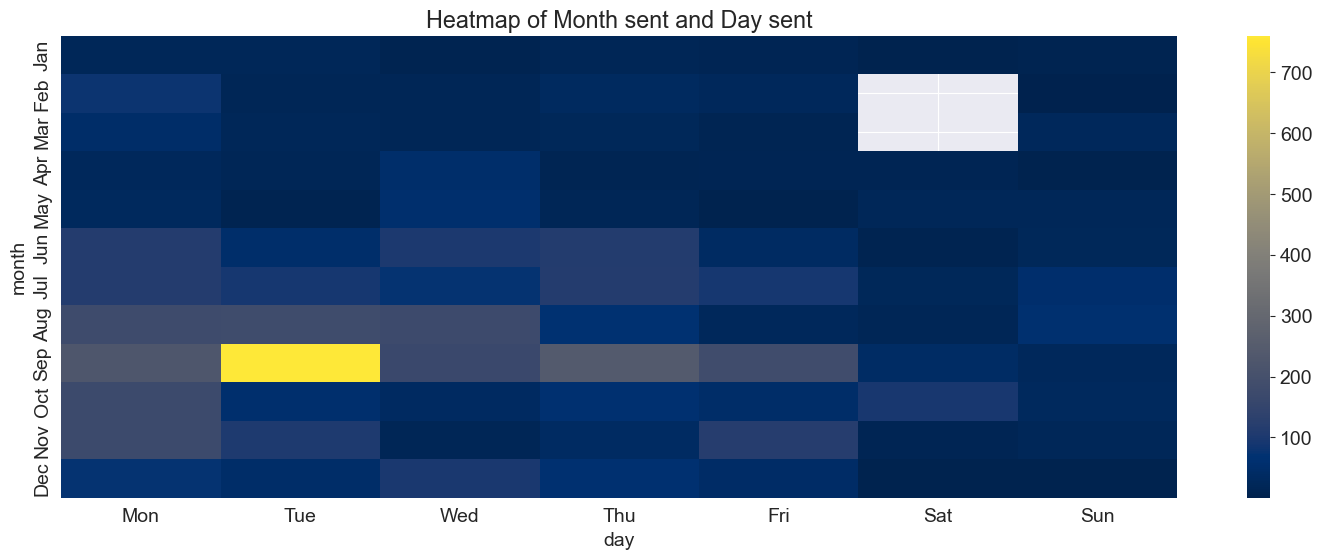

In [37]:
# Better Readablity

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (18, 6)

# Beautifying Default Styles using Seaborn,
sns.set_style("darkgrid")

# Pre-Processing by month and day,
grouped_by_month_and_day = df3.groupby(['month', 'day']).sum().reset_index()[['month', 'day', 'message_count']]

# creating a pivot table,
pt = grouped_by_month_and_day.pivot_table(index = 'month', columns = 'day', values = 'message_count').reindex(index = months, columns = days)

# PLOT: heatmap.
sns.heatmap(pt, cmap = 'cividis');
plt.title('Heatmap of Month sent and Day sent');

# Saving the plots;
plt.savefig('month_day_heatmap.svg', format = 'svg')

### Most used words in the chat.

Using ``WordCloud`` module in Python.

In [38]:
comment_words = ' '

# stopwords --> Words to be avoided while forming the WordCloud,
# removed group_notifications like 'joined', 'deleted';
# removed really common words like "yeah" and "okay".
stopwords = STOPWORDS.update(['group', 'link', 'invite', 'joined', 'message', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted'])


# iterate through the DataFrame.
for val in df3.message.values:
    
    # typecaste each val to string.
    val = str(val) 
    
    # split the value.
    tokens = val.split() 
    
    # Converts each token into lowercase.
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 8).generate(comment_words) 

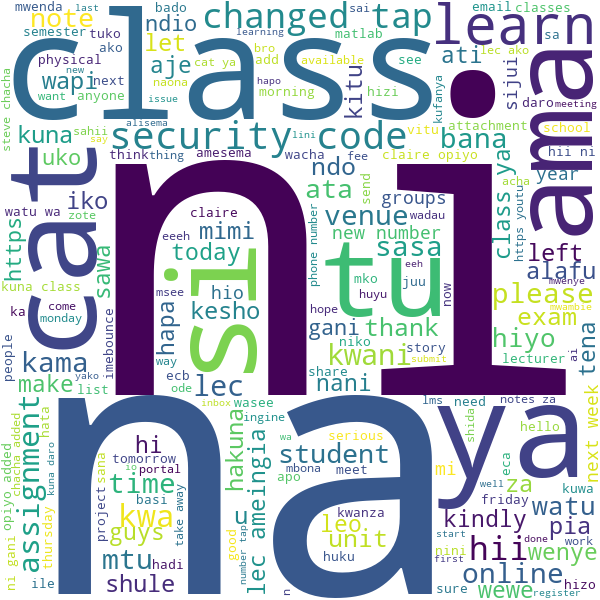

In [39]:
wordcloud.to_image()

### Conclusion

The insights were really interesting to look at!

We first loaded the data as a .txt file coverted it using RawtoDF function.

Then we added helper columns, manipulated datetime entries.

Then, we started analysing our whatsapp data!

Here is what we looked at!

1. Overall frequency of total messages on the group.

2. Top 10 most active days.

3. Top 10 active users on the group.

Ghosts present in the group. (no ghost users atleast everybody has sent a message)

4. Top 10 users most sent media.

Claire Opiyo (CO) beats everyone by a mile!

5. Top 10 most used emojis.

using the emoji module!

6. Most active hours and weekdays.

Heatmaps of weekdays and months.
Most active hours, weekdays, and months.

7. Most used words - WordCloud